In [1]:
import torch
import numpy as np
from torch import nn
from torch import optim
from torch.autograd import Variable
import sys
gpu_id=0

# Main code for Concrete Dropout

In [2]:
class ConcreteDropout(nn.Module):
    """This module allows to learn the dropout probability for any given input layer.
    ```python
        # as the first layer in a model
        model = nn.Sequential(ConcreteDropout(Linear_relu(1, nb_features),
        input_shape=(batch_size, 1), weight_regularizer=1e-6, dropout_regularizer=1e-5))
    ```
    `ConcreteDropout` can be used with arbitrary layers, not just `Dense`,
    for instance with a `Conv2D` layer:
    ```python
        model = nn.Sequential(ConcreteDropout(Conv2D_relu(channels_in, channels_out),
        input_shape=(batch_size, 3, 128, 128), weight_regularizer=1e-6,
        dropout_regularizer=1e-5))
    ```
    # Arguments
        layer: a layer Module.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """
    def __init__(self, layer, input_shape, weight_regularizer=1e-6,
                 dropout_regularizer=1e-5, init_min=0.1, init_max=0.1):
        super(ConcreteDropout, self).__init__()
        # Post drop out layer
        self.layer = layer
        # Input dim for regularisation scaling
        self.input_dim = np.prod(input_shape[1:])
        # Regularisation hyper-parameters
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        # Initialise p_logit
        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        self.p_logit = nn.Parameter(torch.Tensor(1))
        nn.init.uniform(self.p_logit, a=init_min, b=init_max)

    def forward(self, x):
        return self.layer(self._concrete_dropout(x))

    def regularisation(self):
        """Computes weights and dropout regularisation for the layer, has to be
        extracted for each layer within the model and added to the total loss
        """
        weights_regularizer = self.weight_regularizer * self.sum_n_square() / (1 - self.p)
        dropout_regularizer = self.p * torch.log(self.p)
        dropout_regularizer += (1. - self.p) * torch.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * self.input_dim
        regularizer = weights_regularizer + dropout_regularizer
        return regularizer

    def _concrete_dropout(self, x):
        """Forward pass for dropout layer
        """
        eps = 1e-7
        temp = 0.1
        self.p = nn.functional.sigmoid(self.p_logit)

        # Check if batch size is the same as unif_noise, if not take care
        unif_noise = Variable(torch.FloatTensor(np.random.uniform(size=tuple(x.size())))).cuda(gpu_id)

        drop_prob = (torch.log(self.p + eps)
                    - torch.log(1 - self.p + eps)
                    + torch.log(unif_noise + eps)
                    - torch.log(1 - unif_noise + eps))
        drop_prob = nn.functional.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob
        retain_prob = 1 - self.p
        x  = torch.mul(x, random_tensor)
        x /= retain_prob
        return x

    def sum_n_square(self):
        """Helper function for paramater regularisation
        """
        sum_of_square = 0
        for param in self.layer.parameters():
            sum_of_square += torch.sum(torch.pow(param, 2))
        return sum_of_square
    
class Linear_relu(nn.Module):
    
    def __init__(self, inp, out):
        super(Linear_relu, self).__init__()
        self.model = nn.Sequential(nn.Linear(inp, out), nn.ReLU())
        
    def forward(self, x):
        return self.model(x)

In [3]:
class Model(nn.Module):
    """Below we define the whole model used in the experiment, which
    consists of three main layers, and two outputlayers for mean and
    log variance
    """
    
    def __init__(self, wr, dr):
        super(Model, self).__init__()
        self.forward_main = nn.Sequential(ConcreteDropout(Linear_relu(1, nb_features), input_shape=(batch_size,1), weight_regularizer=wr, dropout_regularizer=dr),
                                         ConcreteDropout(Linear_relu(nb_features, nb_features), 
                                                         input_shape=(batch_size,nb_features), weight_regularizer=wr, dropout_regularizer=dr),
                                         ConcreteDropout(Linear_relu(nb_features, nb_features), 
                                                         input_shape=(batch_size,nb_features), weight_regularizer=wr, dropout_regularizer=dr))
        self.forward_mean = ConcreteDropout(Linear_relu(nb_features, D), 
                                            input_shape=(batch_size,nb_features), weight_regularizer=wr, dropout_regularizer=dr)
        self.forward_logvar = ConcreteDropout(Linear_relu(nb_features, D), 
                                              input_shape=(batch_size,nb_features), weight_regularizer=wr, dropout_regularizer=dr)
        
    def forward(self, x):
        x = self.forward_main(x)
        mean = self.forward_mean(x)
        log_var = self.forward_logvar(x)
        return mean, log_var

    def heteroscedastic_loss(self, true, mean, log_var):
        precision = torch.exp(-log_var)
        return torch.sum(precision * (true - mean)**2 + log_var)
    
    def regularisation_loss(self):
        reg_loss = self.forward_main[0].regularisation()+self.forward_main[1].regularisation()+self.forward_main[2].regularisation()
        reg_loss += self.forward_mean.regularisation()
        reg_loss += self.forward_logvar.regularisation()
        return reg_loss

# Set up experiment 

In [4]:
Ns = [10, 25, 50, 100, 1000, 10000] # Number of data points
Ns = np.array(Ns)
nb_epochs = [2000, 1000, 500, 200, 20, 2]
nb_val_size = 1000 # Validation size
nb_features = 1024 # Hidden layer size
Q = 1 # Data dimensionality
D = 1 # One mean, one log_var
K_test = 20 # Number of MC samples
nb_reps = 3 # Number of times to repeat experiment
batch_size = 20
l = 1e-4 # Lengthscale

In [5]:
def gen_data(N):
    """
    Function to generate data
    """
    sigma = 1e0  # ground truth
    X = np.random.randn(N, Q)
    w = 2.
    b = 8.
    Y = X.dot(w) + b + sigma * np.random.randn(N, D)
    return X, Y

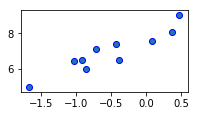

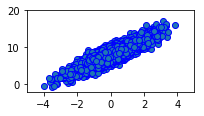

In [6]:
import pylab
%matplotlib inline

X, Y = gen_data(10)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
# pylab.savefig('data_10.pdf', bbox_inches='tight')
pylab.show()

X, Y = gen_data(10000)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
pylab.xlim([-5, 5])
pylab.ylim([-2, 20])
# pylab.savefig('data_10000.pdf', bbox_inches='tight')
pylab.show()

# Define fit and evaluation functions

In [7]:
def fit_model(nb_epoch, X, Y):
    N = X.shape[0]
    wr = l**2. / N
    dr = 2. / N
    model = Model(wr, dr)
    model = model.cuda(gpu_id)
    optimizer = optim.Adam(model.parameters())
    
    for i in range(nb_epoch):
        old_batch = 0
        for batch in range(int(np.ceil(X.shape[0]/batch_size))):
            batch = (batch + 1)
            _x = X[old_batch: batch_size*batch]
            _y = Y[old_batch: batch_size*batch]
            
            x = Variable(torch.FloatTensor(_x)).cuda(gpu_id)
            y = Variable(torch.FloatTensor(_y)).cuda(gpu_id)
            
            mean, log_var = model(x)
            
            loss = model.heteroscedastic_loss(y, mean, log_var) + model.regularisation_loss()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model

In [8]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, K_test, means, logvar):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    k = K_test
    N = Y_true.shape[0]
    mean = means 
    logvar = logvar
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5
    return pppp, rmse

In [9]:
def plot(X_train, Y_train, X_val, Y_val, means):
    indx = np.argsort(X_val[:, 0])
    _, (ax1, ax2, ax3, ax4) = pylab.subplots(1, 4,figsize=(12, 1.5), sharex=True, sharey=True)
    ax1.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax1.set_title('Train set')
    ax2.plot(X_val[indx, 0], np.mean(means, 0)[indx], color='skyblue', lw=3)
    ax2.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax2.set_title('+Predictive mean')
    for mean in means:
        ax3.scatter(X_val[:, 0], mean, c='b', alpha=0.2, lw=0)
    ax3.plot(X_val[indx, 0], np.mean(means, 0)[indx], color='skyblue', lw=3)
    ax3.set_title('+MC samples on validation X')
    ax4.scatter(X_val[:, 0], Y_val[:, 0], c='r', alpha=0.2, lw=0)
    ax4.set_title('Validation set')
    pylab.show()

# Run the experiment

2000


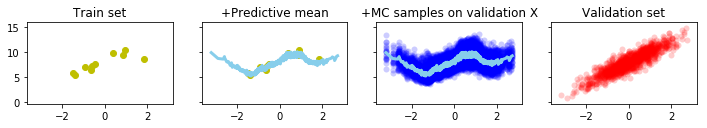

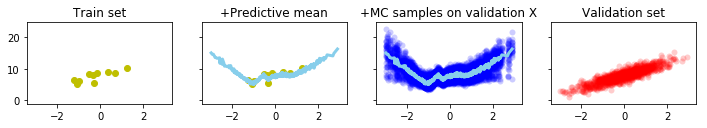

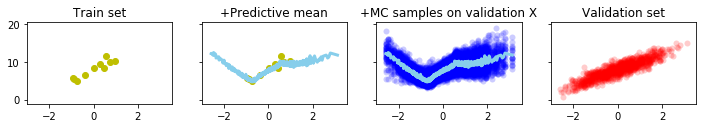

10 2000 - 1.9972558772627285 0.08601817697550526 [0.06126967 0.39897382 0.39423513 0.39553675 0.40388337]  -  1.0000005960462701 1.072438377263964
1000


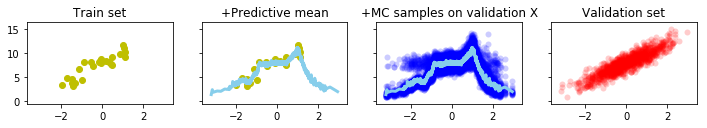

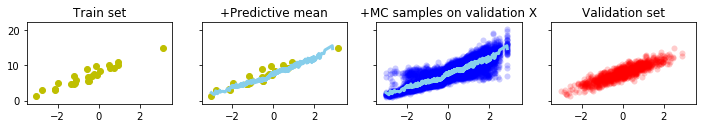

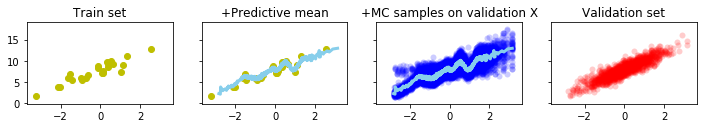

25 1000 - 1.6769662189885894 0.3815682149414521 [0.06281737 0.3798245  0.36434355 0.3677373  0.40271112]  -  1.3629303401322157 0.9723425363088344
500


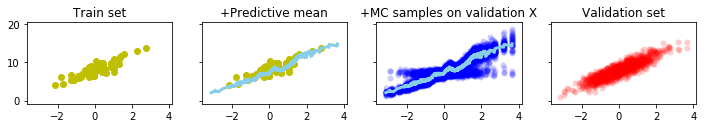

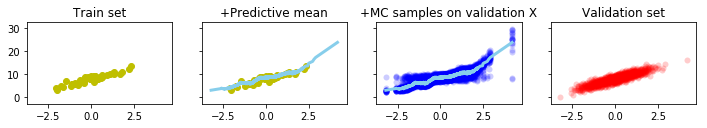

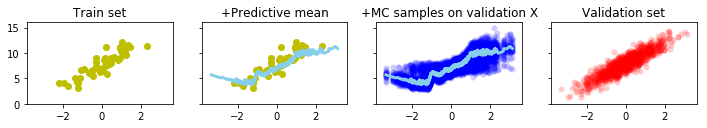

50 500 - 1.2550585496502118 0.06949886604581272 [0.06235377 0.27086723 0.25082877 0.25716045 0.32282513]  -  1.0000557883913375 0.7409118933659246
200


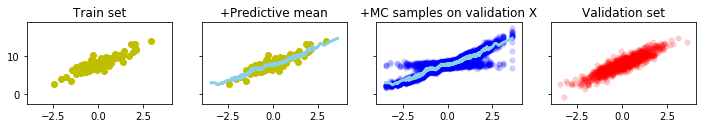

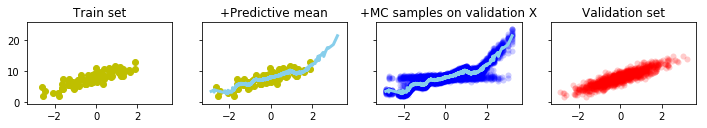

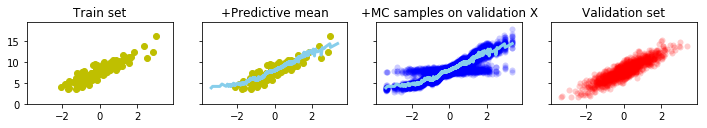

100 200 - 1.111402718718909 0.037815841871729546 [0.06639261 0.16022705 0.13711363 0.13798378 0.22134213]  -  1.0185051208314926 0.6390442069123938
20


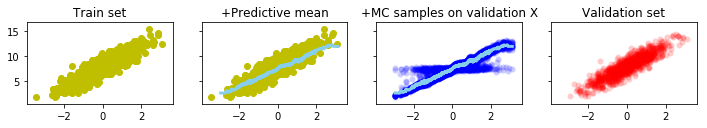

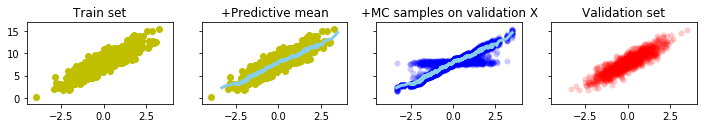

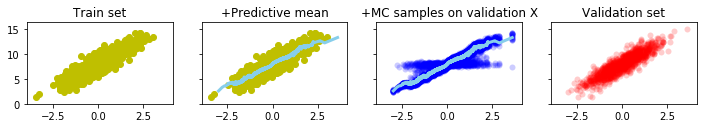

1000 20 - 1.0978736963234133 0.051478362792862414 [0.04844937 0.05515969 0.05134457 0.06311297 0.09440312]  -  1.0277268888287128 0.44626210003965255
2


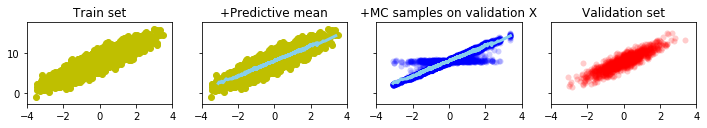

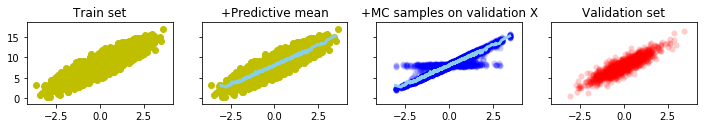

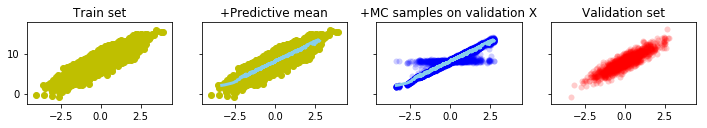

10000 2 - 0.9975959693099741 0.01263461369258264 [0.03698151 0.04099889 0.03985639 0.03981471 0.08708167]  -  1.0109327053799495 0.3970512321755208


In [10]:
results = []
for N, nb_epoch in zip(Ns, nb_epochs):
    rep_results = []
    print(nb_epoch)
    for i in range(nb_reps):
        X, Y = gen_data(N + nb_val_size)
        X_train, Y_train = X[:N], Y[:N]
        X_val, Y_val = X[N:], Y[N:]
        model = fit_model(nb_epoch, X_train, Y_train)
        model.eval()
        MC_samples = [model(Variable(torch.FloatTensor(X_val)).cuda(gpu_id)) for _ in range(K_test)]
        means = torch.stack([tup[0] for tup in MC_samples]).view(K_test, X_val.shape[0]).cpu().data.numpy()
        logvar = torch.stack([tup[1] for tup in MC_samples]).view(K_test, X_val.shape[0]).cpu().data.numpy()
        pppp, rmse = test(Y_val, K_test, means, logvar)
        epistemic_uncertainty = np.var(means, 0).mean(0)
        logvar = np.mean(logvar, 0)
        aleatoric_uncertainty = np.exp(logvar).mean(0)
        ps = np.array([module.p.cpu().data.numpy()[0] for module in model.modules() if hasattr(module, 'p')])
        plot(X_train, Y_train, X_val, Y_val, means)
        rep_results += [(rmse, ps, aleatoric_uncertainty, epistemic_uncertainty)]
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[1] for r in rep_results], 0)
    aleatoric_uncertainty = np.mean([r[2] for r in rep_results])
    epistemic_uncertainty = np.mean([r[3] for r in rep_results])
    print(N, nb_epoch, '-', test_mean, test_std_err, ps, ' - ', aleatoric_uncertainty**0.5, epistemic_uncertainty**0.5)
    sys.stdout.flush()
    results += [rep_results]

In [11]:
import pickle
with open('concrete-dropout.pkl', 'wb') as f:
    pickle.dump(results, f)

In [13]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_aleatoric_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
best_epistemic_uncertainty = np.array([[r[3] for r in result] for result in results]).T.squeeze()
print(best_tests.mean(0))
print(best_ps.mean(1))

[1.99725588 1.67696622 1.25505855 1.11140272 1.0978737  0.99759597]
[[0.06126967 0.39897382 0.39423513 0.39553675 0.40388337]
 [0.06281737 0.3798245  0.36434355 0.3677373  0.40271112]
 [0.06235377 0.27086723 0.25082877 0.25716045 0.32282513]
 [0.06639261 0.16022705 0.13711363 0.13798378 0.22134213]
 [0.04844937 0.05515969 0.05134457 0.06311297 0.09440312]
 [0.03698151 0.04099889 0.03985639 0.03981471 0.08708167]]


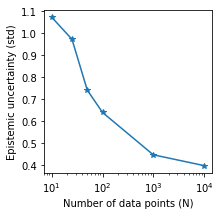

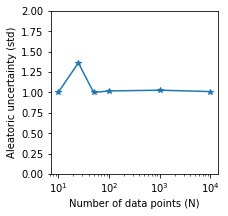

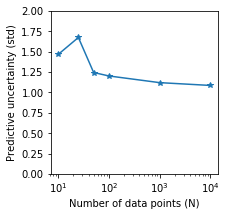

In [14]:
import pylab
%matplotlib inline

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
# pylab.savefig('epistemic.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_aleatoric_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Aleatoric uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
# pylab.savefig('aleatoric.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(Ns, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
# pylab.savefig('predictive.pdf', bbox_inches='tight')
pylab.show()

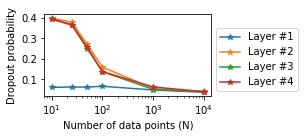

In [15]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(Ns, p, '-*', label='Layer #' + str(i+1))
#     pylab.fill_between(Ns, p + p_std, p - p_std, alpha=0.25)
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
# pylab.savefig('dropout_prob.pdf', bbox_inches='tight')
pylab.show()